In [1]:
# Dataset: https://paperswithcode.com/dataset/lip

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%load_ext tensorboard

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import EarlyStopping
import matplotlib.colors as mcolors
import keras
from keras import layers, Model, mixed_precision
import tensorflow as tf
import datetime
from utils import *

2025-01-28 18:38:38.598935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738085918.674918     798 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738085918.698873     798 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-28 18:38:38.895261: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# Set global policy for mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print(f"Compute dtype: {policy.compute_dtype}, Variable dtype: {policy.variable_dtype}")

Compute dtype: float16, Variable dtype: float32


In [7]:
#DATA_PATH = "/content/data"
DATA_PATH = "./data"
BATCH_SIZE = 32
TARGET_SIZE = (256, 256)
CLASSES_CLUSTERS = {
    0: [0],                 # Background
    1: [1, 2, 4],           # Head Accesories (Hat, Hair, Sunglasses)
    2: [5, 6, 7, 11],       # Upper Body Clothing (UpperClothes, Dress, Coat, Scarf)
    3: [9, 10, 12],         # Lower Body Clothing (Pants, Skirt, Jumpsuits)
    4: [14, 15, 3],         # Hands and Arms (Left-arm, Right-arm, Glove)
    5: [8, 16, 17, 18, 19], # Legs and Feet (Socks, Left-leg, Right-leg, Left-shoe, Right-shoe)
    6: [13]                 # Face
}

CLUSTERS_LABELS = {
    0: "Background",
    1: "Head Accesories",
    2: "Upper Body Clothing",
    3: "Lower Body Clothing",
    4: "Hands and Arms",
    5: "Legs and Feet",
    6: "Face"
}
SEMANTIC_CLASSES = len(CLASSES_CLUSTERS)
LOG_DIR = DATA_PATH + "/logs/fit/"

In [8]:
def imshow(img, variant="image"):
    colors = plt.cm.tab20.colors[:len(CLUSTERS_LABELS)]
    cmap = mcolors.ListedColormap(colors)
    if variant == "image":
        img = img.astype("uint8")
        plt.imshow(img)
    elif variant == "annotation":
        img = np.argmax(img, axis=-1)
        plt.imshow(img, cmap=cmap)
        if CLUSTERS_LABELS:
            # Create legend
            handles = [
                plt.Line2D(
                    [0], [0],
                    color=cmap(idx),
                    lw=4,
                    label=label
                )
                for idx, label in CLUSTERS_LABELS.items()
            ]
            plt.legend(
                handles=handles,
                bbox_to_anchor=(1.05, 1), loc="upper left",
                borderaxespad=0.0,
                title="Clusters"
            )
    plt.axis("off")
    plt.show()

In [9]:
class DataLoader(keras.utils.Sequence):
    def __init__(self, data_type = "train", **kwargs):
        super().__init__(**kwargs)
        self.batch_size = BATCH_SIZE
        self.data_type  = data_type
        self.target_size = TARGET_SIZE
        self.images_dir_path = os.path.join(DATA_PATH, "images", data_type)
        self.annotations_dir_path = os.path.join(DATA_PATH, "annotations", data_type)
        self.files_names = self.get_files_names()

    def __getitem__(self, idx):
        batch_files_names = self.files_names[idx * self.batch_size: (idx+1) * self.batch_size]
        images = [self.load_image(file_name) for file_name in batch_files_names]
        annotations = [self.load_annotation(file_name) for file_name in batch_files_names]
        return np.array(images), np.array(annotations)

    def get_files_names(self):
        return [name[:-4] for name in os.listdir(self.images_dir_path)]

    def load_image(self, file_name):
        img = load_img(os.path.join(self.images_dir_path, f"{file_name}.jpg"), target_size=self.target_size)
        return img_to_array(img)

    def load_annotation(self, file_name):
        img = load_img(os.path.join(self.annotations_dir_path, f"{file_name}.png"), target_size=self.target_size, color_mode="grayscale")
        img = img_to_array(img).squeeze()
        clusters = np.zeros((*TARGET_SIZE, len(CLASSES_CLUSTERS)))
        for cluster_index, semantic_classes in CLASSES_CLUSTERS.items():
            for semantic_class in semantic_classes:
                clusters[img == semantic_class, cluster_index] = 1
        return clusters

    def __len__(self):
        threshold = 10_000
        if self.data_type == "val":
            threshold = 1_000
        #return min(len(self.files_names), threshold) // self.batch_size
        return len(self.files_names) // self.batch_size

In [10]:
train_gen = DataLoader("train")
val_gen = DataLoader("val")

In [11]:
print(train_gen[0][0].shape)
print(train_gen[0][1].shape)

(32, 256, 256, 3)
(32, 256, 256, 7)


#### Example instance

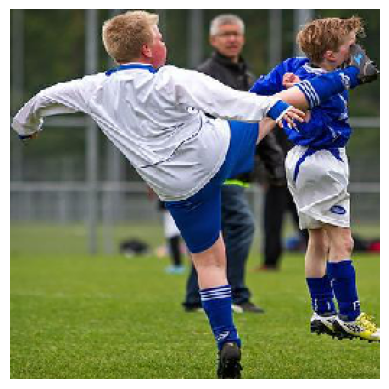

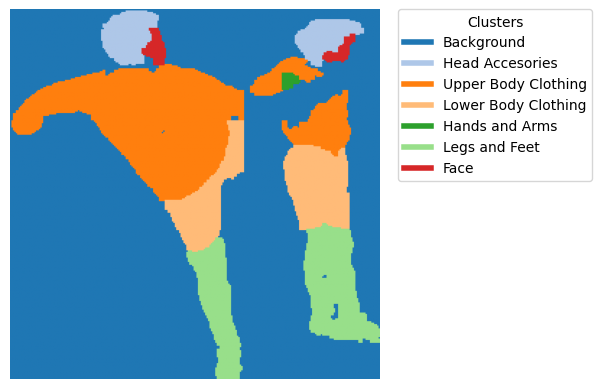

In [12]:
batch_number = 2
instance_number = 25
imshow(train_gen[batch_number][0][instance_number])
imshow(train_gen[batch_number][1][instance_number], variant="annotation")

In [13]:
class Predictor:
    def __init__(self, train_gen, val_gen):
        self.models = dict()
        self.train_gen = train_gen
        self.val_gen = val_gen

    def add_model(self, name, model, optimizer = "Adam"):
        self.compile_model(model, optimizer)
        self.train_model(name, model)
        self.save_model(name, model)
        self.models[name] = model

    def compile_model(self, model, optimizer):
        if optimizer == "Adam":
            optimizer = keras.optimizers.Adam(learning_rate=1e-4)
        elif optimizer == "SGD":
            optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)
        elif optimizer == "RMSprop":
            optimizer = keras.optimizers.RMSprop(learning_rate=1e-4, rho=0.9)
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',  # Handles integer labels directly
            metrics=['categorical_accuracy']
        )
        model.summary()

    def train_model(self, name, model):
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            verbose=1,
            restore_best_weights=True
        )

        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR + name, histogram_freq=1)
        model.fit(
            self.train_gen,
            validation_data=self.val_gen,
            epochs=50,
            callbacks=[early_stopping, tensorboard_callback]
        )

    def save_model(self, name, model):
        model.save(os.path.join(DATA_PATH, "models", f"{name}_model.keras"))

    def predict(self, model_name, test_img):
        return self.models[model_name].predict(np.expand_dims(test_img, axis=0))[0]

    def load_model(self, model_name):
        self.models[model_name] = keras.models.load_model(os.path.join(DATA_PATH, "models", f"{model_name}_model.keras"))

    def evaluate(self, model_name):
        return self.models[model_name].evaluate(self.val_gen)

### Training different Architectures

In [14]:
# predictor = Predictor(train_gen, val_gen)
# predictor.add_model("deeplab", get_deeplab_model(input_shape=(*TARGET_SIZE, 3), num_classes=SEMANTIC_CLASSES))
# predictor.add_model("unet", get_unet_model(input_shape=(*TARGET_SIZE, 3), num_classes=SEMANTIC_CLASSES))
# predictor.add_model("segnet", get_segnet_model(input_shape=(*TARGET_SIZE, 3), num_classes=SEMANTIC_CLASSES))

### Testing a few optimizers

In [15]:
# predictor = Predictor(train_gen, val_gen)
# optimizers_names = ["Adam", "SGD", "RMSprop"]
# for optimizer_name in optimizers_names:
#     predictor.add_model(f"deeplab_{optimizer_name}", get_deeplab_model(input_shape=(*TARGET_SIZE, 3), num_classes=SEMANTIC_CLASSES), optimizer_name)

In [16]:
#models_names = ["deeplab", "unet", "segnet", "deeplab_Adam", "deeplab_SGD", "deeplab_RMSprop"]
models_names = ["deeplab"]
predictor = Predictor(train_gen, val_gen)
for model_name in models_names:
    predictor.load_model(model_name)

I0000 00:00:1738085925.469535     798 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


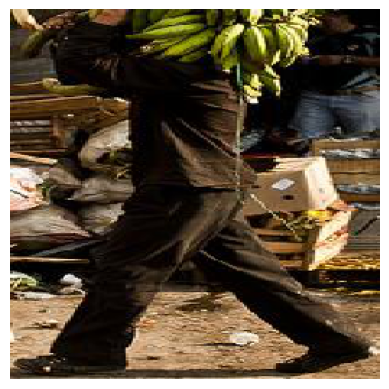

I0000 00:00:1738085930.261296    1234 service.cc:148] XLA service 0x7f6e94004400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738085930.262044    1234 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-01-28 18:38:50.311516: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738085930.646693    1234 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


I0000 00:00:1738085936.335231    1234 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


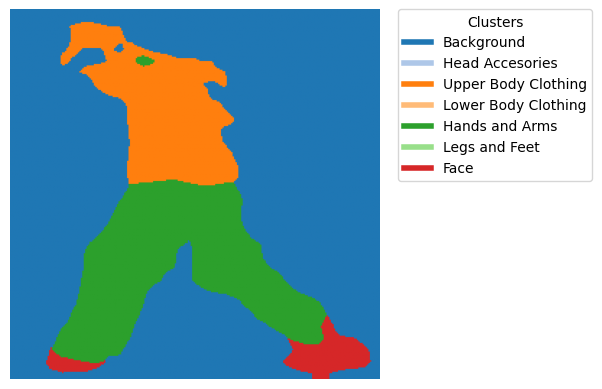

In [17]:
test_dir = os.path.join(DATA_PATH, "images", "test")
test_files_names = os.listdir(test_dir)
instance_number = 11
test_img = load_img(os.path.join(test_dir, test_files_names[instance_number]), target_size=TARGET_SIZE)
test_img = img_to_array(test_img)
imshow(test_img)
prediction = predictor.predict("deeplab", test_img)
imshow(prediction, variant="annotation")

### Models evaluations

In [18]:
models_names = ["deeplab", "unet", "segnet", "deeplab_Adam", "deeplab_SGD", "deeplab_RMSprop", "final"]
predictor = Predictor(train_gen, val_gen)
for model_name in models_names:
    predictor.load_model(model_name)
    accuracy = predictor.evaluate(model_name)
    print(f"{model_name} accuracy: {accuracy}")

312/312 ━━━━━━━━━━━━━━━━━━━━ 276s 851ms/step - categorical_accuracy: 0.8082 - loss: 0.5663
deeplab accuracy: [0.5604235529899597, 0.8086752891540527]
312/312 ━━━━━━━━━━━━━━━━━━━━ 142s 403ms/step - categorical_accuracy: 0.7889 - loss: 0.6000
unet accuracy: [0.5934131145477295, 0.7897659540176392]
312/312 ━━━━━━━━━━━━━━━━━━━━ 124s 387ms/step - categorical_accuracy: 0.7817 - loss: 0.6056
segnet accuracy: [0.6031826734542847, 0.7822568416595459]
312/312 ━━━━━━━━━━━━━━━━━━━━ 127s 392ms/step - categorical_accuracy: 0.8144 - loss: 0.5965
deeplab_Adam accuracy: [0.5856688618659973, 0.8153783082962036]
312/312 ━━━━━━━━━━━━━━━━━━━━ 128s 397ms/step - categorical_accuracy: 0.7836 - loss: 0.6009
deeplab_SGD accuracy: [0.5917190313339233, 0.7854107022285461]
312/312 ━━━━━━━━━━━━━━━━━━━━ 124s 383ms/step - categorical_accuracy: 0.7905 - loss: 0.5860
deeplab_RMSprop accuracy: [0.5797344446182251, 0.7910626530647278]
312/312 ━━━━━━━━━━━━━━━━━━━━ 118s 363ms/step - categorical_accuracy: 0.8351 - loss: 0.4